# Transforms

Medical images are unique in that the structure of the data is quite consistent across individuals. Think about the brain - it has the same overall shape but with small nuances that cause big differences in outcomes.

We can use this to our advantage by applying random transforms - also known as data augmentation - to our images during model training in order to get more out of the images available to us. By applying random transforms in the right way, it really is like getting a completely new participant in our dataset. 

In this tutorial, you will be introduced to both fixed (i.e., preprocessing) and random (i.e., augmentation) transforms in nitrain. Applying transforms in nitrain is incredibly powerful, but our philosophy of working only on actual medical image objects, rather than arrays, may have a learning curve for some.


## Types of transforms

As mentioned in the introduction, all transforms work on images - not arrays. Therefore, it helps to think about transforms in terms of what affect they can have on images. In general, there are three aspects of images that can be transformed:

- intensity : relative values of specific pixels / voxels
- spatial : relative arrangement of pixels / voxels
- structural : how the underlying image data is stored

Transforms do not always fit neatly into one signle category, and some transforms have no effect on the image at all (we call these "utility transforms"). Still, it's a good mental model to have.


### Intensity transforms


### Spatial transforms


### Structural transforms


### Utility transforms


### Other transforms

##  Using transforms

Let's start by creating an in-memory dataset of 3D brain images along with associated chronological age values.

In [1]:
import ants
image = ants.image_read(ants.get_data('r16'))

In [2]:
from nitrain import transforms as tx

## Using fixed transforms

Transforms that give you the same result every time can be called fixed transforms. Fixed transforms should only be used for your datasets and not on your loaders. It is more efficient this way, since the dataset classes can take advantage of pre-computing or caching fixed transforms so that they only have to be done once, rather than every time the image is served to the model during training.

Let's see how fixed transforms work on datasets. We'll start by creating a dataset.

In [3]:
from nitrain.datasets import MemoryDataset
import numpy as np

# create a memory dataset with images as input and continuous value as output
img = ants.image_read(ants.get_data('r16')) # 2D images
dataset = MemoryDataset(x = [img for _ in range(5)],
                        y = np.random.normal(60, 20, 5))

This dataset has no transforms. When you access any records from the dataset, you will simply get the image as input and the associated continuous value as output.

In [4]:
x_raw, y_raw = dataset[0]
print(x_raw)
print(y_raw)

ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 256)
	 Spacing    : (1.0, 1.0)
	 Origin     : (0.0, 0.0)
	 Direction  : [1. 0. 0. 1.]

51.032652905764394


Now, we can add an `x_transform` to the dataset and see how it works. We often need to downsample our large images, so let's choose a transform that does this.

In [5]:
dataset_new = MemoryDataset(x = dataset.x,
                            y = dataset.y,
                            x_transforms=tx.Resample((64,64)))

x_raw, y_raw = dataset_new[0]
print(x_raw)
print(y_raw)

ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (64, 64)
	 Spacing    : (4.0476, 4.0476)
	 Origin     : (0.0, 0.0)
	 Direction  : [1. 0. 0. 1.]

51.032652905764394


As you can see, the image that we get from our dataset with a `tx.Resample` transform has dimensions of (64, 64) rather than (256, 256). 

### Chaining transforms

Of course, one transform is usually not enough! We can easily chain transforms together in a list, and doing so will mean that each transform is applied one after the other. Let's add another transform. 

In [11]:
dataset_new = MemoryDataset(x = dataset.x,
                            y = dataset.y,
                            x_transforms=[tx.Resample((64,64)),
                                         tx.RangeNormalize(0, 1)])

x_raw, y_raw = dataset_new[0]
print(x_raw)
print(f'Min: {x_raw.min()}, Max: {x_raw.max()}')

ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (64, 64)
	 Spacing    : (4.0476, 4.0476)
	 Origin     : (0.0, 0.0)
	 Direction  : [1. 0. 0. 1.]

Min: 0.0, Max: 1.0


By chaining two transforms together, we were able to first downsample the image and then normalize the pixel values to be between 0 and 1.

### Co-transforms

In some scenarios, you may need to apply the same transform to both inputs (x) and outputs (y). It can be possible to add the same transform as part of the `x_transforms` and `y_tranforms` arguments, but it is easier and safer to supply such transforms via the `co_transforms` argument. 

Besides using a different argument, there is no difference in how you actually define or use the transforms. In fact, nearly all transforms can automatically be used as co-transforms. Keep in mind, however, that co-transforms will be applied after any individual transforms have been applied. 

The most common use case for co-transforms is when both your input and output values are images. In that case, you may want to register them both to a common template. Here, we will show how co-transforms make this easy:

In [17]:
img = ants.image_read(ants.get_data('r16'))
template = ants.image_read(ants.get_data('r64'))
dataset = MemoryDataset(x = [img for _ in range(5)],
                            y = [img for _ in range(5)],
                            x_transforms=[tx.AlignWithTemplate(template)])

Here is the original image and the template, along with the aligned input image and the un-aligned output image.

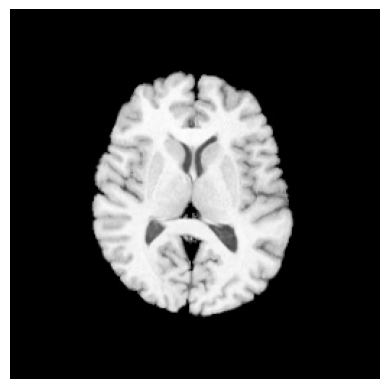

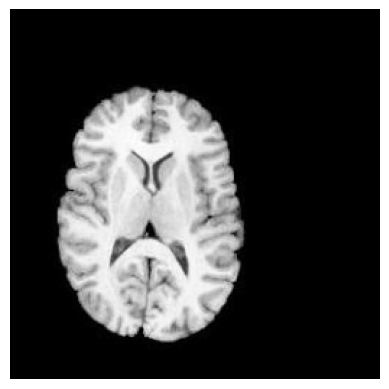

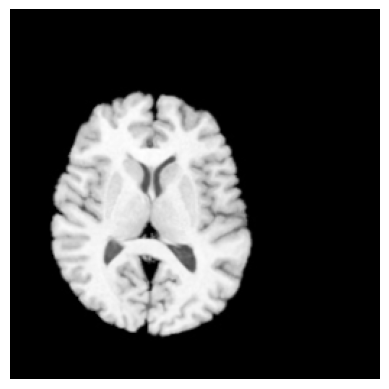

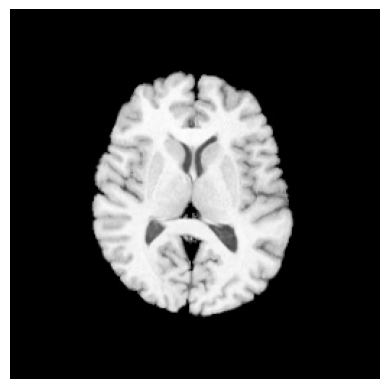

In [18]:
ants.plot(img) # raw image
ants.plot(template) # template

x_raw, y_raw = dataset[0]
ants.plot(x_raw) # aligned image
ants.plot(y_raw) # unaligned image

By supplying a co-transform, we can make sure that both the input and the output images are aligned to the template together.

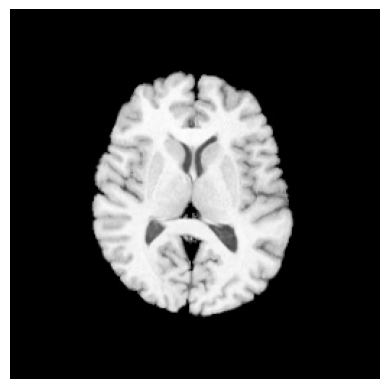

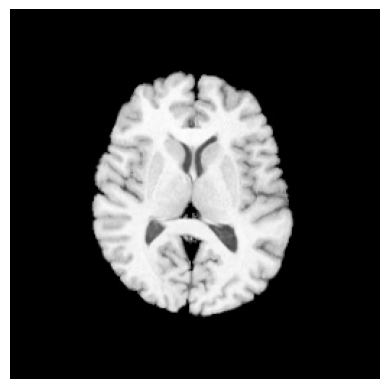

In [22]:
img = ants.image_read(ants.get_data('r16'))
template = ants.image_read(ants.get_data('r64'))
dataset = MemoryDataset(x = [img for _ in range(5)],
                        y = [img for _ in range(5)],
                        co_transforms=[tx.AlignWithTemplate(template)])

x_raw, y_raw = dataset[0]
ants.plot(x_raw) # aligned input image
ants.plot(y_raw) # aigned output image

## Using random transforms